In [26]:
import sys
sys.path.insert(1, '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/asapp/')

from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import logging
from scannotation import ASAPP
from data._dataloader import DataSet
from util import _topics


import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from data import _sim 
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

import joblib

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

dl = DataSet()
dl.config = args
dl.initialize_path()
dl.initialize_data()
dl.load_data()
print(dl.inpath)
print(dl.outpath)
# logging.basicConfig(filename=dl.outpath+'_model.log',
# 						format='%(asctime)s %(levelname)-8s %(message)s',
# 						level=logging.INFO,
# 						datefmt='%Y-%m-%d %H:%M:%S')

# asap = ASAPP(adata=dl,tree_min_leaf=5,tree_max_depth=1000, factorization='MVB',max_iter=10,n_pass=10)
# asap.factorize()
# asap.save_model()

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/hbcc/hbcc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/hbcc/hbcc


In [27]:
asap = joblib.load(dl.outpath+'_model_vb.pkl')

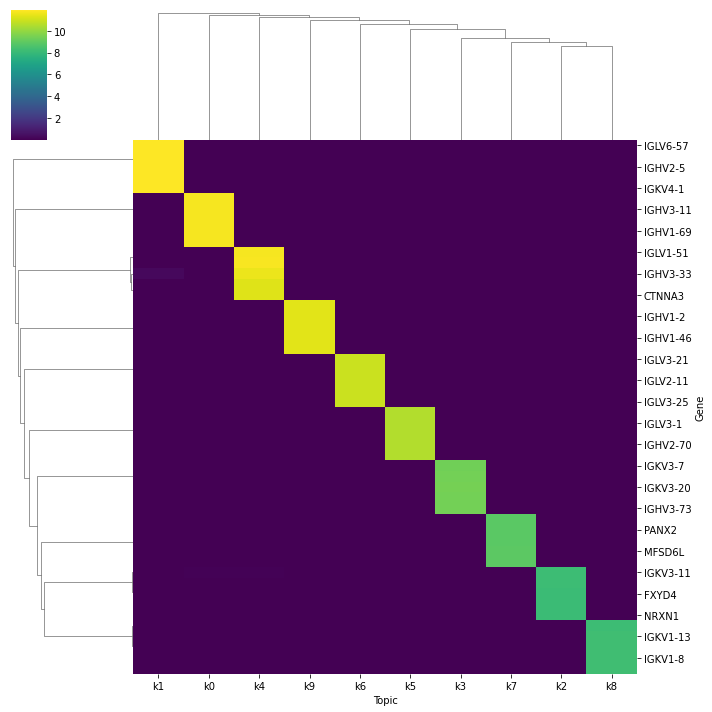

In [28]:
df_beta = pd.DataFrame(asap.Ebeta)
df_beta.columns = dl.cols
df_top = _topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=5)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [29]:
df_pl = pd.read_csv(dl.outpath+'_prior_label.csv.gz')
df_pl.columns = ['cell','cell_type']
df_pl

,cell,cell_type
0,CID3586_AAGACCTCAGCATGAG,Endothelial
1,CID3586_AAGGTTCGTAGTACCT,Endothelial
2,CID3586_ACCAGTAGTTGTGGCC,Endothelial
3,CID3586_ACCCACTAGATGTCGG,Endothelial
4,CID3586_ACTGATGGTCAACTGT,Endothelial
...,...,...
100059,CID4398_TCAGGTAGTACTCAAC,Myeloid
100060,CID4398_TCTATTGTCGCCATAA,Myeloid
100061,CID4398_TCTTTCCCAGTAAGCG,Myeloid
100062,CID4398_TGCCCATGTTACGGAG,Myeloid


In [30]:
df_sel = df_pl[df_pl['cell_type'].isin(['T-cells','Cancer Epithelial'])]
minix = pd.DataFrame(dl.mtx)
minix.index = dl.rows
minix = minix[minix.index.isin(df_sel['cell'].values)]
minix = minix.sample(n=2000)
minix.shape

(2000, 19798)

In [31]:
predicted_params = asap.predict_theta(minix.to_numpy(),predict_iter=50)

In [32]:
import umap
df_theta = pd.DataFrame(predicted_params['theta_a']/predicted_params['theta_b'])
df_umap= pd.DataFrame()
df_umap['cell'] = minix.index
df_umap['topic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic,umap1,umap2
0,CID4398_CATCAAGGTAAGAGGA,3,12.091943,-1.114449
1,CID44971_TGTGTTTGTCTGCCAG,8,7.939192,10.923805
2,CID3586_TCATTACGTCTGGAGA,3,9.073663,13.557204
3,CID44991_TGACTAGTCTTACCTA,2,1.379169,3.913534
4,CID44991_ACTGAGTTCCGAAGAG,2,2.042926,4.046398
...,...,...,...,...
1995,CID4523_GGAAAGCCAAGTACCT,5,-2.579975,7.536407
1996,CID3921_GTGCGGTTCCTGTAGA,3,7.095252,13.218307
1997,CID4040_CGTTCTGAGCTATCCA,8,8.968440,13.453979
1998,CID44991_CACTCCAGTAATCGTC,5,1.263659,2.653594


In [33]:
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic,umap1,umap2,cell_type
0,CID4398_CATCAAGGTAAGAGGA,3,12.091943,-1.114449,T-cells
1,CID44971_TGTGTTTGTCTGCCAG,8,7.939192,10.923805,T-cells
2,CID3586_TCATTACGTCTGGAGA,3,9.073663,13.557204,T-cells
3,CID44991_TGACTAGTCTTACCTA,2,1.379169,3.913534,Cancer Epithelial
4,CID44991_ACTGAGTTCCGAAGAG,2,2.042926,4.046398,Cancer Epithelial
...,...,...,...,...,...
1995,CID4523_GGAAAGCCAAGTACCT,5,-2.579975,7.536407,Cancer Epithelial
1996,CID3921_GTGCGGTTCCTGTAGA,3,7.095252,13.218307,T-cells
1997,CID4040_CGTTCTGAGCTATCCA,8,8.968440,13.453979,T-cells
1998,CID44991_CACTCCAGTAATCGTC,5,1.263659,2.653594,Cancer Epithelial


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'ASAP')

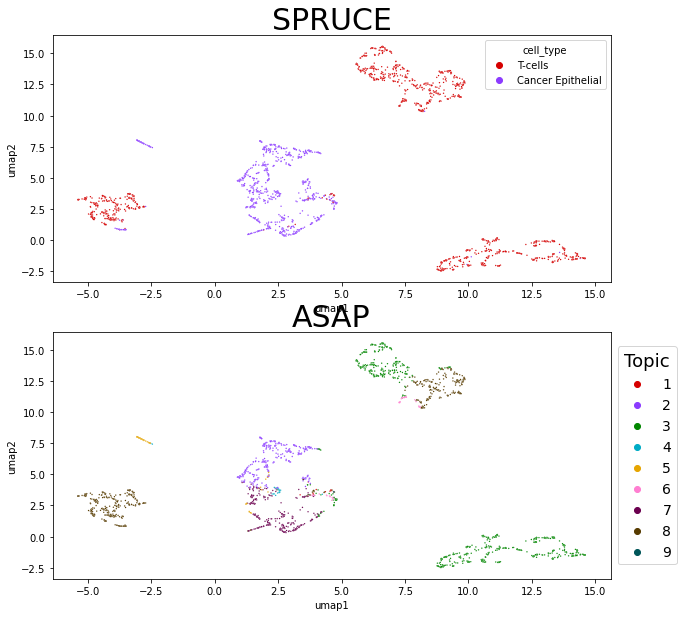

In [34]:
plt.rcParams["figure.figsize"] = (10,10)
figure,axis = plt.subplots(2,1)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=2,palette=cp,legend=True,ax=axis[0])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("SPRUCE",fontsize=30)


cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic',s=2,palette=cp,legend=True,ax=axis[1])
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("ASAP",fontsize=30)


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


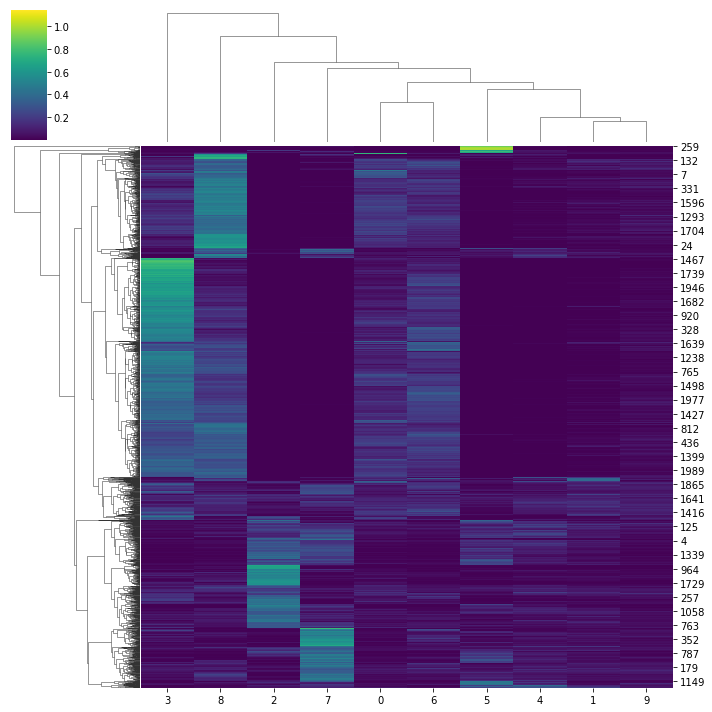

In [35]:
sns.clustermap(df_theta,cmap='viridis')